
SOLUTION BY POLICY ITERATION:



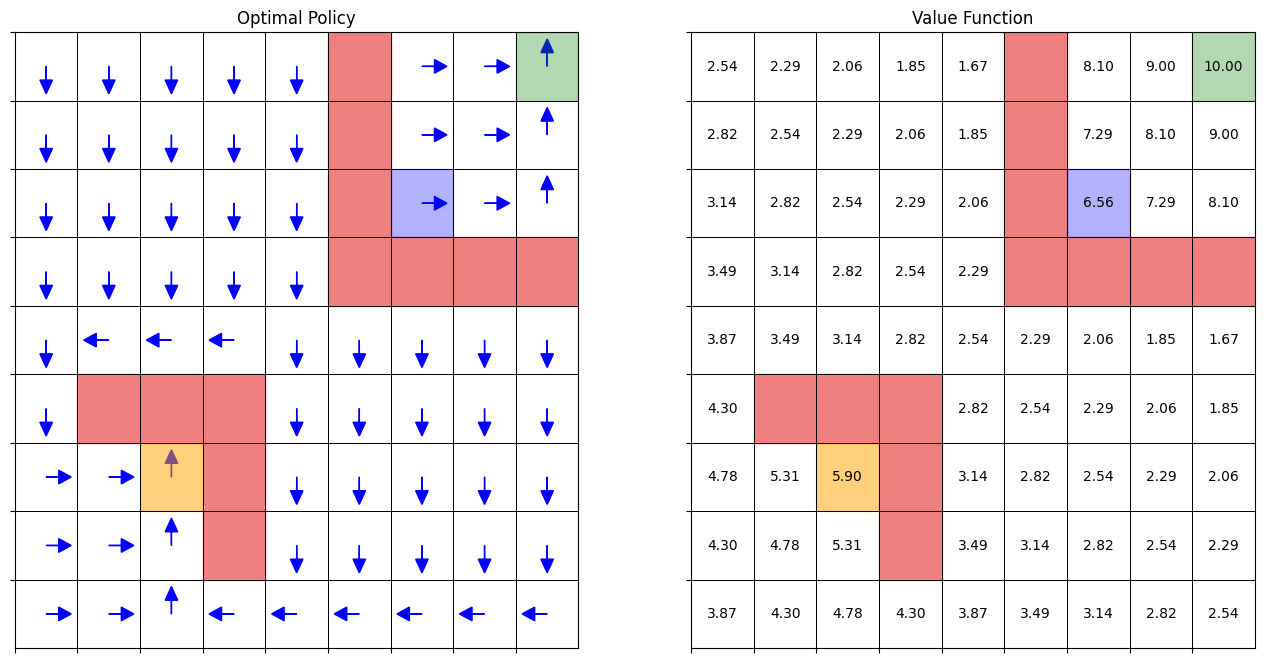

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MDP:
    def __init__(self, states, actions, transition_probabilities, rewards, discount_factor):
        self.states = states
        self.actions = actions
        self.transition_probabilities = transition_probabilities
        self.rewards = rewards
        self.discount_factor = discount_factor

    def get_transition_probabilities(self, state, action):
        return self.transition_probabilities[state][action]

    def get_reward(self, state, action):
        return self.rewards[state]

def value_iteration(mdp, epsilon=1e-6):
    V = {state: 0 for state in mdp.states}

    while True:
        delta = 0
        for state in mdp.states:
            max_value = float('-inf')
            for action in mdp.actions:
                expected_value = sum(prob * (mdp.get_reward(state, action) + mdp.discount_factor * V[next_state]) for next_state, prob in mdp.get_transition_probabilities(state, action).items())
                max_value = max(max_value, expected_value)

            delta = max(delta, abs(max_value - V[state]))
            V[state] = max_value

        if delta < epsilon:
            break

    policy = {}
    for state in mdp.states:
        best_action = None
        best_value = float('-inf')
        for action in mdp.actions:
            expected_value = sum(prob * (mdp.get_reward(state, action) + mdp.discount_factor * V[next_state]) for next_state, prob in mdp.get_transition_probabilities(state, action).items())
            if expected_value > best_value:
                best_value = expected_value
                best_action = action
        policy[state] = best_action

    return V, policy

def policy_evaluation(policy, mdp, V, epsilon=1e-6):
    while True:
        delta = 0
        for state in mdp.states:
            action = policy[state]
            expected_value = sum(prob * (mdp.get_reward(state, action) + mdp.discount_factor * V[next_state]) for next_state, prob in mdp.get_transition_probabilities(state, action).items())
            delta = max(delta, abs(expected_value - V[state]))
            V[state] = expected_value

        if delta < epsilon:
            break

    return V

def policy_iteration(mdp):
    policy = {state: np.random.choice(mdp.actions) for state in mdp.states}
    V = {state: 0 for state in mdp.states}

    while True:
        V = policy_evaluation(policy, mdp, V)
        policy_stable = True

        for state in mdp.states:
            old_action = policy[state]
            action_values = {}
            for action in mdp.actions:
                action_values[action] = sum(prob * (mdp.get_reward(state, action) + mdp.discount_factor * V[next_state]) for next_state, prob in mdp.get_transition_probabilities(state, action).items())
            best_action = max(action_values, key=action_values.get)

            if best_action != old_action:
                policy_stable = False

            policy[state] = best_action

        if policy_stable:
            break

    return V, policy

def create_maze_mdp(size, walls, teleport_cell, teleport_target):
    states = [(i, j) for i in range(size) for j in range(size) if (i, j) not in walls]
    actions = ['up', 'down', 'left', 'right']
    transition_probabilities = {}
    rewards = {}
    goal_state = (0, size-1)

    for state in states:
        transition_probabilities[state] = {}
        for action in actions:
            next_state = get_next_state(state, action, size, walls, teleport_cell, teleport_target)
            transition_probabilities[state][action] = {next_state: 1.0}
        rewards[state] = 1.0 if state == goal_state else 0.0

    discount_factor = 0.9
    return MDP(states, actions, transition_probabilities, rewards, discount_factor)

def get_next_state(state, action, size, walls, teleport_cell, teleport_target):
    i, j = state
    if state == teleport_cell:
        return teleport_target
    if action == 'up':
        next_state = (max(i-1, 0), j)
    elif action == 'down':
        next_state = (min(i+1, size-1), j)
    elif action == 'left':
        next_state = (i, max(j-1, 0))
    elif action == 'right':
        next_state = (i, min(j+1, size-1))

    return next_state if next_state not in walls else state

def plot_policy(ax, maze_size, policy, goal_state, walls, teleport_cell, teleport_target):
    ax.set_xlim(0, maze_size)
    ax.set_ylim(0, maze_size)

    for i in range(maze_size):
        for j in range(maze_size):
            ax.plot([j, j], [0, maze_size], color='black', linewidth=0.5)
            ax.plot([0, maze_size], [i, i], color='black', linewidth=0.5)

    for i in range(maze_size):
        for j in range(maze_size):
            if (i, j) not in walls:
                action = policy[(i, j)]
                center_x, center_y = j + 0.5, i + 0.5
                if action == 'up':
                    ax.arrow(center_x, center_y, 0, -0.2, head_width=0.2, head_length=0.2, fc='blue', ec='blue')
                elif action == 'down':
                    ax.arrow(center_x, center_y, 0, 0.2, head_width=0.2, head_length=0.2, fc='blue', ec='blue')
                elif action == 'left':
                    ax.arrow(center_x, center_y, -0.2, 0, head_width=0.2, head_length=0.2, fc='blue', ec='blue')
                elif action == 'right':
                    ax.arrow(center_x, center_y, 0.2, 0, head_width=0.2, head_length=0.2, fc='blue', ec='blue')

    ax.add_patch(plt.Rectangle((goal_state[1], goal_state[0]), 1, 1, fill=True, color='green', alpha=0.3))

    for wall in walls:
        ax.add_patch(plt.Rectangle((wall[1], wall[0]), 1, 1, fill=True, color='lightcoral'))

    ax.add_patch(plt.Rectangle((teleport_cell[1], teleport_cell[0]), 1, 1, fill=True, color='orange', alpha=0.5))
    ax.add_patch(plt.Rectangle((teleport_target[1], teleport_target[0]), 1, 1, fill=True, color='blue', alpha=0.3))

    ax.set_xticks(np.arange(maze_size))
    ax.set_yticks(np.arange(maze_size))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    ax.set_title('Optimal Policy')

    ax.invert_yaxis()

def plot_value_function(ax, maze_size, V, goal_state, walls, teleport_cell, teleport_target):
    ax.set_xlim(0, maze_size)
    ax.set_ylim(0, maze_size)

    for i in range(maze_size):
        for j in range(maze_size):
            ax.plot([j, j], [0, maze_size], color='black', linewidth=0.5)
            ax.plot([0, maze_size], [i, i], color='black', linewidth=0.5)

    for i in range(maze_size):
        for j in range(maze_size):
            if (i, j) in walls:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='lightcoral'))
            else:
                value = V.get((i, j), 0)
                ax.text(j + 0.5, i + 0.5, f'{value:.2f}', va='center', ha='center', color='black')

    ax.add_patch(plt.Rectangle((goal_state[1], goal_state[0]), 1, 1, fill=True, color='green', alpha=0.3))
    ax.add_patch(plt.Rectangle((teleport_cell[1], teleport_cell[0]), 1, 1, fill=True, color='orange', alpha=0.5))
    ax.add_patch(plt.Rectangle((teleport_target[1], teleport_target[0]), 1, 1, fill=True, color='blue', alpha=0.3))

    ax.set_xticks(np.arange(maze_size))
    ax.set_yticks(np.arange(maze_size))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    ax.set_title('Value Function')

    plt.gca().invert_yaxis()

maze_size = 9

walls = [(5,1),(5,2),(5,3),(6,3),(7,3),(0,5),(1,5),(2,5),(3,5),(3,6),(3,7),(3,8)]

teleport_cell = (6, 2)
teleport_target = (2, 6)

mdp = create_maze_mdp(maze_size, walls, teleport_cell, teleport_target)

# Solve the MDP using policy iteration
V, policy = policy_iteration(mdp)

goal_state = (0, maze_size - 1)
print()
print("SOLUTION BY POLICY ITERATION:")
print()
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

plot_policy(axs[0], maze_size, policy, goal_state, walls, teleport_cell, teleport_target)
plot_value_function(axs[1], maze_size, V, goal_state, walls, teleport_cell, teleport_target)

plt.show()


SOLUTION BY VALUE ITERATION:



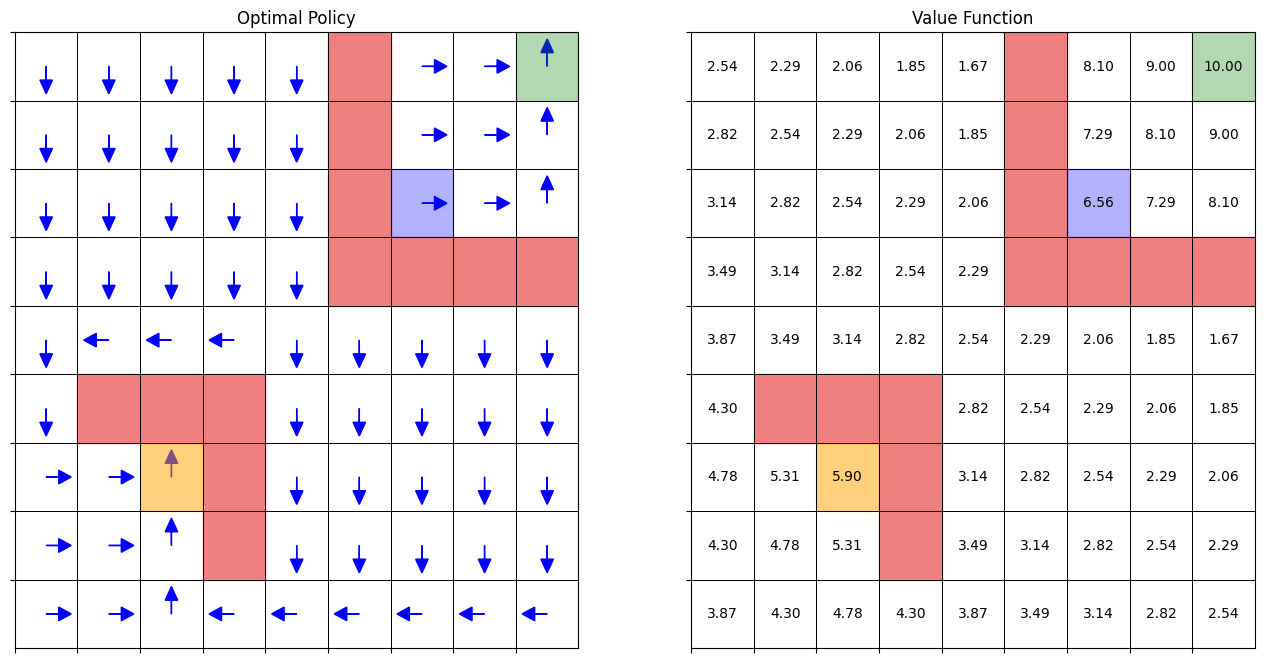

In [ ]:
V, policy = value_iteration(mdp)
goal_state = (0, maze_size - 1)
print()
print("SOLUTION BY VALUE ITERATION:")
print()
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

plot_policy(axs[0], maze_size, policy, goal_state, walls, teleport_cell, teleport_target)
plot_value_function(axs[1], maze_size, V, goal_state, walls, teleport_cell, teleport_target)
plt.show()